In [1]:
import pandas as pd

path_map = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/kuairec_caption_category.csv"

# read even if the file is a bit malformed (lets pandas sniff the delimiter)
m = pd.read_csv(path_map, engine="python", on_bad_lines="skip")

# if the two columns aren't present (e.g., it's tab-separated), try TSV
if not {"first_level_category_id", "first_level_category_name"}.issubset(m.columns):
    m = pd.read_csv(path_map, sep="\t", engine="python", on_bad_lines="skip")

# 1) unique ids
ids = sorted(m["first_level_category_id"].dropna().unique().tolist())
print("unique first_level_category_id:", ids)

# 2) id → name table, sorted as 1,2,3,...,-124 (put -124 last)
tbl = (
    m[["first_level_category_id", "first_level_category_name"]]
    .drop_duplicates()
    .copy()
)
tbl["__unk"] = (tbl["first_level_category_id"] == -124).astype(int)
tbl = tbl.sort_values(["__unk", "first_level_category_id"]).drop(columns="__unk").reset_index(drop=True)

tbl

unique first_level_category_id: [-124.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 418.0, 667.0]


,first_level_category_id,first_level_category_name
0,1.0,舞蹈
1,2.0,音乐
2,3.0,游戏
3,4.0,美妆
4,5.0,时尚
5,6.0,明星娱乐
6,7.0,运动
7,8.0,颜值
8,9.0,喜剧
9,10.0,旅游


In [2]:
# Step 1 — load from the given path
PATH = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/features_full.parquet"

# Load only the columns we need
keep = ["user_id", "session", "timestamp", "i_top_category_id", "y_complete", "burst_id"]
df = pd.read_parquet(PATH, columns=keep)

print(df.shape)
print(df.head(3))


(12530806, 6)
   user_id  session     timestamp i_top_category_id  y_complete  burst_id
0        0        1  1.593879e+09                28           1         1
1        0        1  1.593879e+09                28           1         1
2        0        1  1.593879e+09                 5           0         1


In [3]:
# replace category "unknown" with -124

import pandas as pd
import numpy as np

col = "i_top_category_id"

# Replace "unknown" with -124 while preserving the column's dtype
if isinstance(df[col].dtype, pd.CategoricalDtype):
    # decide whether categories are numeric or string-like
    cat_dtype = df[col].cat.categories.dtype
    target_val = -124 if np.issubdtype(cat_dtype, np.number) else "-124"

    # mask all textual "unknown" (any case/whitespace)
    mask = df[col].astype(str).str.strip().str.lower().eq("unknown")

    # make sure target exists as an allowed category
    if target_val not in df[col].cat.categories.tolist():
        df[col] = df[col].cat.add_categories([target_val])

    # set and then drop the "unknown" category if present
    df.loc[mask, col] = target_val
    try:
        df[col] = df[col].cat.remove_categories(["unknown"])
    except (ValueError, TypeError):
        # category label type may not match exactly; safe to ignore
        pass
else:
    # non-categorical: simple replace; dtype (e.g., object) is preserved
    mask = df[col].astype(str).str.strip().str.lower().eq("unknown")
    df.loc[mask, col] = -124


In [4]:
# Get category list while preserving dtype

# category 30 is missing
if isinstance(df[col].dtype, pd.CategoricalDtype):
    cats = df[col].cat.categories.tolist()
else:
    cats = sorted(pd.unique(df[col].dropna()).tolist())

K = len(cats)
print(f"K = {K}")
print("Categories:", cats)

K = 39
Categories: ['-124', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '5', '6', '7', '8', '9']


i_top_category_id
28    2390185
8     1132144
6      800832
34     713031
5      622058
7      504565
1      499760
12     475583
11     467616
26     465358
Name: count, dtype: int64


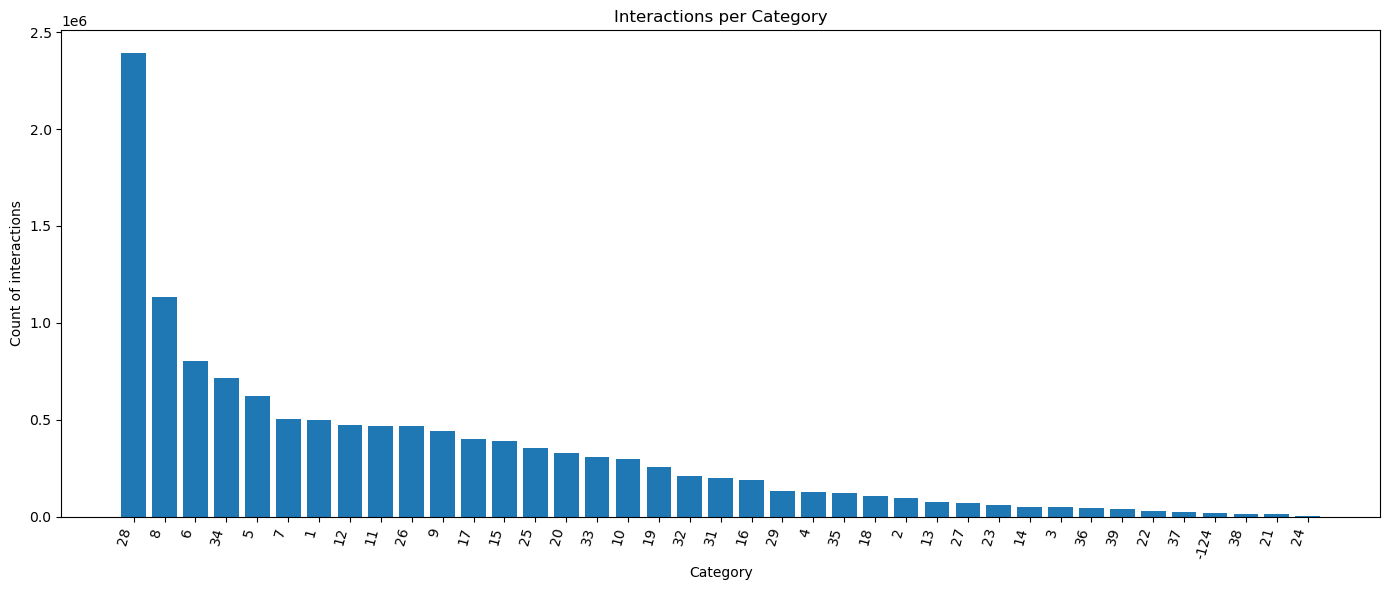

In [6]:
import pandas as np
import matplotlib.pyplot as plt

col = "i_top_category_id"

# Count interactions per category (after your unknown→-124 normalization)
if isinstance(df[col].dtype, pd.CategoricalDtype):
    counts = df[col].value_counts().sort_values(ascending=False)
else:
    counts = df[col].astype(str).value_counts().sort_values(ascending=False)

print(counts.head(10))  # quick peek

# --- Bar chart for ALL categories (39) ---
plt.figure(figsize=(14, 6))
x = counts.index.astype(str)
y = counts.values
plt.bar(x, y)
plt.title("Interactions per Category")
plt.xlabel("Category")
plt.ylabel("Count of interactions")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()



In [7]:
import pandas as pd
import numpy as np

# =========================================
# Step X — Compute B1 beliefs (λ=0, G unused)
# Output format:
#   ['user_id','session_id','burst_id','date'] + 39 belief columns  (total 43 cols)
# Beliefs are p_t at the START of each session; ALL B1 sessions included.
# =========================================

# ---- Params ----
eta        = 1.0   # prior total mass ⇒ alpha0 = (eta/K) * 1
s_E        = 1.0   # small smoothing for exposure PMF R_t
clip_floor = 1e-9  # numerical floor

# ---- 1) Slice to B1 and build day/date helpers (keep all days; tag first 4 as warm-up) ----
b1 = df.loc[df["burst_id"] == 1].copy()

# ensure timestamp is datetime
if not pd.api.types.is_datetime64_any_dtype(b1["timestamp"]):
    s = pd.to_numeric(b1["timestamp"], errors="coerce")
    # auto-detect unit by magnitude
    m = s.dropna().abs()
    if m.empty:
        b1["timestamp"] = pd.to_datetime(b1["timestamp"], errors="coerce", utc=True)
    else:
        maxv = m.max()
        unit = "s" if maxv < 1e11 else "ms" if maxv < 1e14 else "us" if maxv < 1e17 else "ns"
        b1["timestamp"] = pd.to_datetime(s, unit=unit, origin="unix", utc=True)

# localize (optional): keep tz-naive date for grouping/ordering
b1_dt = b1["timestamp"]
b1["b1_date"] = (b1_dt.dt.tz_convert(None).dt.date if b1_dt.dt.tz is not None else b1_dt.dt.date)

# assign B1 day index and warm-up flag (first 4 calendar days)
b1_dates = sorted(b1["b1_date"].dropna().unique().tolist())
date2idx = {d: i + 1 for i, d in enumerate(b1_dates)}
b1["day_idx_b1"] = b1["b1_date"].map(date2idx).astype("Int16")
b1["is_warmup"]  = b1["day_idx_b1"].le(4)

In [8]:
b1.head()

,user_id,session,timestamp,i_top_category_id,y_complete,burst_id,b1_date,day_idx_b1,is_warmup
0,0,1,2020-07-04 16:08:23.437999964+00:00,28,1,1,2020-07-04,1,True
1,0,1,2020-07-04 16:13:41.296999931+00:00,28,1,1,2020-07-04,1,True
2,0,1,2020-07-04 16:16:06.687000036+00:00,5,0,1,2020-07-04,1,True
3,0,1,2020-07-04 16:20:26.792000055+00:00,28,0,1,2020-07-04,1,True
4,0,1,2020-07-04 16:43:05.128000020+00:00,6,0,1,2020-07-04,1,True


In [9]:
# ---- 2) Freeze category vocabulary  ----
col = "i_top_category_id"
cats = sorted(b1[col].astype(str).dropna().unique().tolist())
K = len(cats)
assert K == 39, f"Expected K=39 categories, got {K}. Categories: {cats}"
cat2idx = {c: i for i, c in enumerate(cats)}

In [10]:
# ---- 3) Aggregate per (user, session): counts per category ----
b1["_cat_str"] = b1[col].astype(str)

grp = b1.groupby(["user_id", "session"], sort=False)

rows = []
Nk_list = []
first_ts = []
dates = []

for (uid, sid), g in grp:
    t0 = g["timestamp"].min()
    d0 = g["b1_date"].iloc[0] if pd.isna(t0) else (t0.tz_convert(None).date() if getattr(t0, "tzinfo", None) else t0.date())

    vc = g["_cat_str"].value_counts()
    N = np.zeros(K, dtype=np.float64)
    for cat_str, cnt in vc.items():
        N[cat2idx[cat_str]] = cnt

    rows.append((uid, sid, d0, t0))
    Nk_list.append(N)
    first_ts.append(t0)
    dates.append(d0)

sess = pd.DataFrame(rows, columns=["user_id", "session_id", "date", "first_ts"])
sess["burst_id"] = 1
Nk = np.vstack(Nk_list)  # shape (S, K)

In [11]:
# ---- 4) Sort sessions by user then time for the recursion order ----
order = np.lexsort((sess["first_ts"].values, sess["user_id"].values))
sess = sess.iloc[order].reset_index(drop=True)
Nk   = Nk[order]

In [12]:
# ---- 5) Build R_t (smoothed exposure PMF) ----
Nk_sum = Nk.sum(axis=1, keepdims=True)
R = (Nk + (s_E / K)) / (Nk_sum + s_E)   # (S, K); each row sums to 1

In [13]:
# ---- 6) Per-user recursion with λ=0 ⇒ α_{t+1} = α_t + R_t
#         Emit p_t = α_t / sum(α_t) at the START of each session ----
S = R.shape[0]
alpha0 = np.full(K, eta / K, dtype=np.float64)
p_rows = np.empty((S, K), dtype=np.float32)

users = sess["user_id"].values
_, starts = np.unique(users, return_index=True)
starts = np.append(starts, S)

for b in range(len(starts) - 1):
    lo, hi = starts[b], starts[b + 1]
    alpha = alpha0.copy()
    for s in range(lo, hi):
        kappa = alpha.sum()
        p_rows[s, :] = (alpha / (kappa if kappa > 0 else 1.0)).astype(np.float32)
        alpha = alpha + R[s, :]
        np.maximum(alpha, clip_floor, out=alpha)

In [14]:
# ---- 7) Assemble the wide output: 43 columns ----
bel_cols = [f"cat::{c}" for c in cats]  # stable category order
out = sess[["user_id", "session_id", "burst_id", "date"]].copy()
out[bel_cols] = p_rows

# ---- 8) Quick sanity checks ----
row_sums = out[bel_cols].sum(axis=1).to_numpy()
print("Rows:", len(out), "| K:", K)
print("Row-sum (min/median/max):",
      float(row_sums.min()), float(np.median(row_sums)), float(row_sums.max())) # make sure the belief vector sum up to one

Rows: 152456 | K: 39
Row-sum (min/median/max): 0.9999993443489075 1.0 1.0000009536743164


In [15]:
# Reorder category columns to: 1, 2, ..., 38, -124
key_cols = ["user_id", "session_id", "burst_id", "date"]

desired = [str(i) for i in range(1, 40)] + ["-124"]
bel_cols_ordered = [f"cat::{c}" for c in desired if f"cat::{c}" in out.columns]

# keep any extra cat columns (if any) at the end
extra = [c for c in out.columns if c.startswith("cat::") and c not in bel_cols_ordered]
bel_cols_final = bel_cols_ordered + extra

out = out[key_cols + bel_cols_final].copy()


In [16]:
out

,user_id,session_id,burst_id,date,cat::1,cat::2,cat::3,cat::4,cat::5,cat::6,...,cat::31,cat::32,cat::33,cat::34,cat::35,cat::36,cat::37,cat::38,cat::39,cat::-124
0,0,1,1,2020-07-04,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,...,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641
1,0,2,1,2020-07-04,0.014652,0.014652,0.014652,0.014652,0.086081,0.086081,...,0.014652,0.014652,0.014652,0.086081,0.014652,0.014652,0.014652,0.014652,0.014652,0.014652
2,0,3,1,2020-07-05,0.180708,0.014042,0.014042,0.014042,0.061661,0.061661,...,0.014042,0.014042,0.014042,0.061661,0.014042,0.014042,0.014042,0.014042,0.014042,0.014042
3,0,4,1,2020-07-05,0.138736,0.013736,0.013736,0.013736,0.049451,0.049451,...,0.013736,0.013736,0.013736,0.049451,0.013736,0.013736,0.013736,0.013736,0.013736,0.013736
4,0,5,1,2020-07-05,0.130281,0.011233,0.011233,0.020757,0.039805,0.049328,...,0.011233,0.011233,0.011233,0.049328,0.011233,0.011233,0.011233,0.011233,0.011233,0.011233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152451,7175,22,1,2020-07-10,0.024800,0.004611,0.004611,0.016716,0.010577,0.060544,...,0.011727,0.039916,0.014841,0.046471,0.004611,0.004611,0.004611,0.004611,0.004611,0.004611
152452,7175,23,1,2020-07-10,0.024279,0.004968,0.004968,0.016547,0.010674,0.058469,...,0.011775,0.038737,0.014753,0.045008,0.004968,0.004968,0.004968,0.004968,0.004968,0.004968
152453,7175,24,1,2020-07-11,0.024454,0.007105,0.004790,0.017044,0.012574,0.059535,...,0.012471,0.039468,0.015325,0.047792,0.004790,0.004790,0.004790,0.004790,0.004790,0.005948
152454,7175,25,1,2020-07-12,0.023562,0.006906,0.004684,0.016448,0.012156,0.063906,...,0.012058,0.041308,0.014798,0.045966,0.004684,0.004684,0.004684,0.004684,0.004684,0.005795


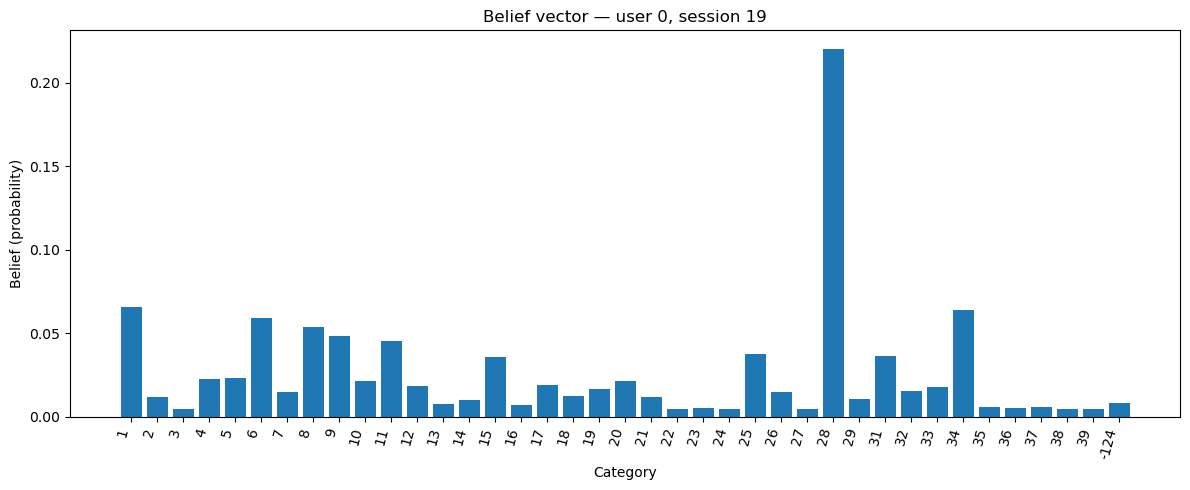

In [17]:
# sanity check: user's 1's last session's belief in burst 1


# pick the first user's last B1 session
bel_cols = [c for c in out.columns if c.startswith("cat::")]
b1_out = out[out["burst_id"] == 1]
uid = b1_out["user_id"].iloc[0]
row = (
    b1_out[b1_out["user_id"] == uid]
    .sort_values(["date", "session_id"])
    .tail(1)
)

# belief vector and labels
belief = row[bel_cols].iloc[0].values
labels = [c.split("cat::", 1)[1] for c in bel_cols]

# bar chart
plt.figure(figsize=(12, 5))
plt.bar(labels, belief)
plt.title(f"Belief vector — user {uid}, session {int(row['session_id'].iloc[0])}")
plt.xlabel("Category")
plt.ylabel("Belief (probability)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

In [19]:
import os

# save beliefs to the prepared directory (Parquet)
save_dir = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared"
os.makedirs(save_dir, exist_ok=True)

parquet_path = os.path.join(save_dir, "b1_beliefs.parquet")
out.to_parquet(parquet_path, index=False)
print("Saved:", parquet_path)

# (optional) also save a CSV
csv_path = os.path.join(save_dir, "b1_beliefs.csv")
out.to_csv(csv_path, index=False)
print("Saved:", csv_path)


Saved: /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_beliefs.parquet
Saved: /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_beliefs.csv
